# Different methods to detect stops points

Présentation de méthodes pour détecter les points stops

## Import de la librairie tracklib

In [1]:
# -*- coding: utf-8 -*-
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


## Présentation de la trace

Présentons tout d'abord la trace sur laquelle les algos de détection des points d'arrêt s'appliqueront. Voir le quickstart aussi qui utilise cette trace.

C'est une trace d'un entrainement de course à pied autour d'une piste. Grosso modo, le coureur faisait des pauses sur place d'une durée d'environ 30 secondes

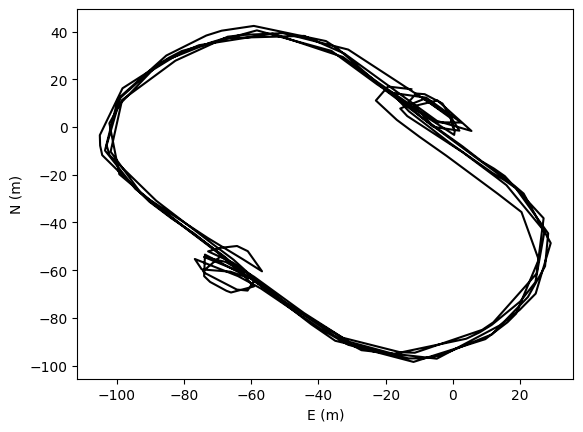

In [2]:
from tracklib.core.ObsTime import ObsTime
from tracklib.io.TrackReader import TrackReader

ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoords()

trace.plot()

import tracklib.algo.Cinematics as Cinematics
AC = Cinematics.computeAbsCurv(trace)

## Import des librairies

In [3]:
import matplotlib.pyplot as plt
import tracklib.core.Utils as utils
from tracklib.plot.Plot import Plot

# On prépare la barre de couleur: gris clair: pas de pause, rouge est stop
COLS = utils.getColorMap((220, 220, 220), (255, 0, 0))

## 1ère méthode: stop_point_with_time_window_criteria

<div class="alert alert-block alert-info">
<b>References: TODO</b> <br/>
</div>

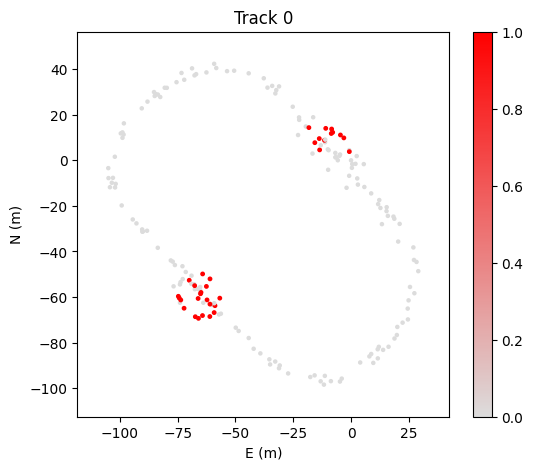

In [4]:
from tracklib.algo.Segmentation import VAL_AF_TIME_WINDOW_NONE, VAL_AF_TIME_WINDOW_MOVE, VAL_AF_TIME_WINDOW_STOP
from tracklib.algo.Segmentation import stop_point_with_time_window_criteria

# -----------------------------------------------------------------------------
# Première méthode
trace.createAnalyticalFeature('stop_point_with_time_window_criteria', VAL_AF_TIME_WINDOW_NONE)
trace.addAnalyticalFeature(stop_point_with_time_window_criteria, 'stop_point_with_time_window_criteria')

trace.plot(type='POINT', af_name='stop_point_with_time_window_criteria', append = False, cmap = COLS)

print ()


## 2ème méthode: stop_point_with_acceleration_criteria

<div class="alert alert-block alert-info">
<b>References: TODO</b> <br/>
</div>

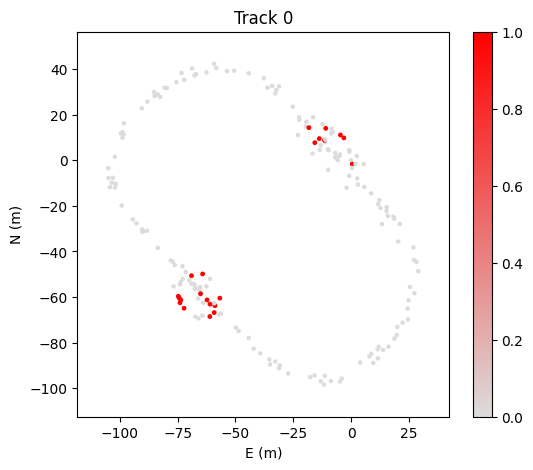

In [5]:
from tracklib.algo.Segmentation import stop_point_with_acceleration_criteria

# -----------------------------------------------------------------------------
# Deuxième méthode
trace.addAnalyticalFeature(stop_point_with_acceleration_criteria)


trace.plot(type='POINT', af_name='stop_point_with_acceleration_criteria', append = False, cmap = COLS)

print ()


## 3ème méthode: findStopsGlobal

<div class="alert alert-block alert-info">
<b>References: TODO</b> <br/>
</div>

In [6]:
from tracklib.algo.Segmentation import findStopsGlobal

# -----------------------------------------------------------------------------
# Troisième méthode 
stops = findStopsGlobal(trace, downsampling=5, diameter=30, duration=15)
# print (len(stops))

trace.createAnalyticalFeature('cost_matrix', VAL_AF_TIME_WINDOW_MOVE)
for i in range(trace.size()):
    for s in range(stops.size()):
        idstop = stops.getObsAnalyticalFeature('id_ini', s)
        if idstop == i:
            trace.setObsAnalyticalFeature('cost_matrix', i, VAL_AF_TIME_WINDOW_STOP)


100% (35 of 35) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Minimal enclosing circles computation:
Optimal split search:


## Méthode 4: stdbscan

<div class="alert alert-block alert-info">
<b>Reference:</b> <br/>
Birant, D., & Kut, A. (2007). ST-DBSCAN: An algorithm for clustering
spatial–temporal data. Data & Knowledge Engineering, 60(1), 208-221.
</div>

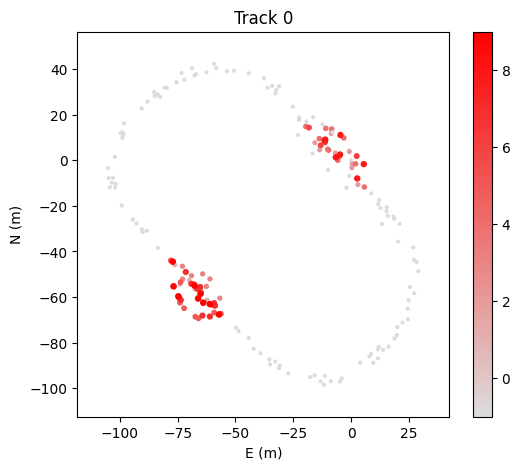

In [7]:
# -----------------------------------------------------------------------------
# Quatrième méthode 

from tracklib.algo.Segmentation import stdbscan

stdbscan(trace, 15, 30, 5, 1)

trace1 = trace.query('SELECT * WHERE stdbscan > -1')
T = trace1.getAnalyticalFeature('stdbscan')


trace.plot(type='POINT', af_name='stdbscan', append = False, cmap = COLS)

# Pour le dernier graphique
# On ajoute l'AF marquant le stop avec dbscan (tous les no cluster >= 0 => 1)
def stopstdbscan(track, i):
    cluster = track.getObsAnalyticalFeature('stdbscan', i)
    if cluster >= 0:
        return 1
    return 0
T = trace.addAnalyticalFeature(stopstdbscan)

## Récapitulatif

Visualisation des stops points par rapport au profil de vitesse

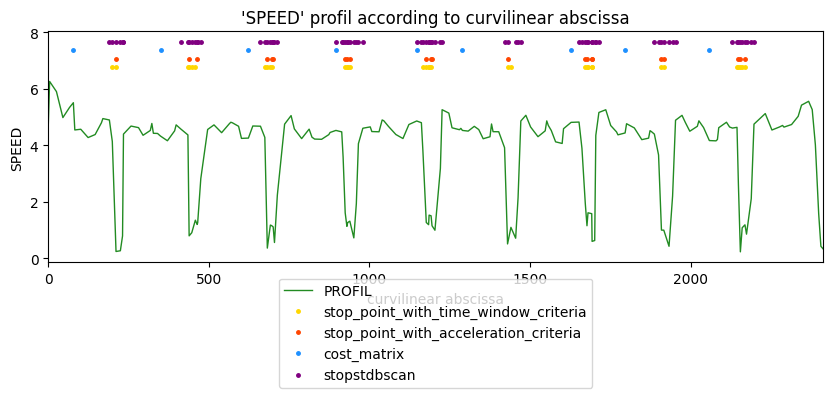

In [10]:
from tracklib.plot.Plot import Plot
plot = Plot(trace)

# -----------------------------------------------------------------------------
# # On dessine

TAB_AFS = ['stop_point_with_time_window_criteria', 
           'stop_point_with_acceleration_criteria', 
           'cost_matrix', 'stopstdbscan']
plot.plotProfil('SPATIAL_SPEED_PROFIL', TAB_AFS)